### This notebook was used for testing and debugging. I've left it in case it is useful for people in the future.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
tree = ET.parse('./page10.xml')
root = tree.getroot()

In [4]:
def xml2csv(xml_path):
    """Convert XML to CSV

    Args:
        xml_path (str): Location of annotated XML file
    Returns:
        pd.DataFrame: converted csv file

    """
    print("xml to csv {}".format(xml_path))
    xml_list = []
    xml_df=pd.DataFrame()
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
            column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
            xml_df = pd.DataFrame(xml_list, columns=column_name)
    except Exception as e:
        print('xml conversion failed:{}'.format(e))
        return pd.DataFrame(columns=['filename,width,height','class','xmin','ymin','xmax','ymax'])
    return xml_df

In [5]:
def get_threshold(areas):
  areas = np.array(sorted(areas))
  threshold = 50
  # print(areas)
  groups = [[areas[0]]]
  diffs = areas[1:] - areas[:-1]
  # print(f'Diffs: {diffs}')
  for i, dif in enumerate(diffs):
    if dif < threshold:
      groups[-1] += [areas[i+1]]
    else:
      groups += [[areas[i+1]]]
  lens = list(map(lambda x: len(x), groups))
  ret = np.mean(groups[np.argmax(lens)])
  return ret

In [6]:
class CheckboxExtractor:
  def __init__(self):
    pass
  
  def find_same_block(self, checkbox, groups):
    for _id in range(len(groups)-1, -1, -1):
      if np.abs(checkbox[0] - np.array(groups[_id][1:])[:,0].mean()) <= 30:
        return _id
    return None

  def has_numbers(self, inputString):
    return any(char.isdigit() for char in inputString)

  def is_question(self, text, group_type=1):
    sub_condic = False
    if group_type == 2:
      sub_condic  = '?' in text
    return self.has_numbers(text[:7]) or '.' in text[:7] or sub_condic

  def check_above_is_question(self, checkbox, lines, line_have_checkbox):
    checkbox_line_num = checkbox[6]
    for i in range(1,4):
      search_line_num = int(checkbox_line_num) - i
      if search_line_num >= 0 and search_line_num not in line_have_checkbox:
        if self.is_question(lines[1][ search_line_num ]) and ( lines[0][search_line_num][0] - 30 < checkbox[0] ) :
          return True
      else: break

    return False

  def find_question_for_group(self, group, lines, line_have_checkbox):
    group_type = group[0]
    top_checkbox = group[1]
    checkbox_line_num = top_checkbox[6]
    question_components = []
    for i in range(1,4):
      search_line_num = int(checkbox_line_num) - i
      if search_line_num >= 0 and search_line_num not in line_have_checkbox:
        question_components += [ lines[1][ search_line_num ] ]
        if self.is_question(lines[1][ search_line_num ], group_type=group_type):
          break
      else: break
    
    return question_components[::-1] 

  def group_checkbox(self, checkboxes, lines):
    
    checkboxes = np.array(sorted(checkboxes, key=lambda x: x[6])) # sort by line
    line_have_checkbox = list(checkboxes[:,6])
    finish_groups = []
    unfinish_groups = []

    for checkbox in checkboxes:

      # print('-----------------------------------------------------------------------')
      # print(f'Checkbox at line: {checkbox[6]}')
      # print(len(unfinish_groups))

      if len(unfinish_groups) == 2:
        unfinish_groups = sorted(unfinish_groups, key=lambda x: x[0])
      if checkbox[6] - 1 not in line_have_checkbox: # Above is text

        group_id = self.find_same_block(checkbox, unfinish_groups)
        if group_id is None: # No unfinish element has same align
          # Create a new unfinish group
          group = [ len(unfinish_groups) + 1, checkbox]
          unfinish_groups += [ group ]

        else:
          if self.check_above_is_question(checkbox, lines, line_have_checkbox):
            # Move the old checkbox to finish_froup and create new element for unfinish_groups
            finish_groups += [unfinish_groups.pop(group_id)]

            # print(f'Moved 1: \n{finish_groups[-1]}')

            if len(unfinish_groups) == 1 and unfinish_groups[0][0] == 2:
              finish_groups += [unfinish_groups.pop(0)]

              # print(f'Moved 2: \n{finish_groups[-1]}')

            group = [ len(unfinish_groups) + 1, checkbox]
            unfinish_groups += [ group ]
            
          else:
            unfinish_groups[ group_id ] += [checkbox]

      else: # Above is not text
        try:
          if np.abs(checkbox[0] - np.array(unfinish_groups[-1][1:])[:,0].mean()) <= 30: # nearest unfinish group has same align
            unfinish_groups[ -1 ] += [checkbox]
          else:
            try:
              finish_groups += [unfinish_groups.pop(-1)]
              # print(f'Moved 3: \n{finish_groups[-1]}')
              unfinish_groups[ -1 ] += [checkbox]
            except:
              # print('Some error might occur here')
              pass
        except: 
          pass
          # print('Bug log')
          # print(len(unfinish_groups))
          # print(checkbox)
    finish_groups += unfinish_groups
    return finish_groups, unfinish_groups


  def is_correct_area(self, contour, expected_area=625, tolerance=200):
   area = cv2.contourArea(contour)
   return abs(area - expected_area) <= tolerance

  def are_bounding_dimensions_correct(self, contour, expected_area=625, tolerance=200, squareness_tolerance=15):
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    return abs(area - expected_area) <= tolerance and abs(w - h) <= squareness_tolerance
    
  def is_contour_square(self, contour, contour_tolerance=0.0015, square_side=25, area_tolerance=200):
    expected_area = square_side * square_side
    area = cv2.contourArea(contour)
    template = np.array([[[0, 0]], [[0, 1]], [[1, 1]], [[1, 0]]], dtype=np.int32)
    return cv2.matchShapes(template, contour, 1, 0.0) <= contour_tolerance and abs(area - expected_area) <= area_tolerance

  def detect_checkbox(self, gray_img):
    thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    bin_thresh_img = 255 - thresh_img
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,30))
    vertical = cv2.morphologyEx(bin_thresh_img, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30,1))
    horizontal = cv2.morphologyEx(bin_thresh_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

    rets = []
    temp_new = vertical | horizontal

    temp_kernel = np.ones((2,2), np.uint8)
    temp_new=cv2.dilate(temp_new,temp_kernel,iterations=1)

    _, labels, stats,_ = cv2.connectedComponentsWithStats(~temp_new, connectivity=8, ltype=cv2.CV_32S)
    # threshold = np.mean(stats[2:][-3:])
    areas = list(filter(lambda x: 400 <= x <= 1000, stats[2:][:,4]))
    threshold = get_threshold(areas)
    # print(f'Threshold: {threshold}')
    ticks = []
    # print(type(stats))
    for x,y,w,h,area in stats[2:]:
      # print(area)
      # if area < 400: continue
      if np.abs(area - threshold) > 50: continue
      rets += [[x,y,w,h]]

    rets = np.array(rets)
    # print(rets.shape)
    rets[:, 2] = rets[:, 0] + rets[:, 2]
    rets[:, 3] = rets[:, 1] + rets[:, 3]
    return rets

  def detect_text(self, gray_img):
    thresh_img = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY)[1]
    details = pytesseract.image_to_data(thresh_img, output_type=Output.DICT, config='--oem 3 --psm 6', lang='eng')
    total_boxes = len(details['text'])
    rets = []
    for sequence_number in range(total_boxes):
      if int(details['conf'][sequence_number]) >10:
        (x, y, w, h) = (details['left'][sequence_number], details['top'][sequence_number], details['width'][sequence_number],  details['height'][sequence_number])
        # ret = cv2.rectangle(ret, (x, y), (x + w, y + h), (0, 255, 0), 2)
        rets += [[x,y,w,h]]
    
    rets = np.array(rets)
    rets[:, 2] = rets[:, 0] + rets[:, 2]
    rets[:, 3] = rets[:, 1] + rets[:, 3]
    return rets

  def detect_text_line(self, gray_img):
    H,W = gray_img.shape
    thresh_img = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY)[1]
    details = pytesseract.image_to_data(thresh_img, output_type=Output.DICT, config='--oem 3 --psm 6', lang='eng')
    line_nums = np.array(details['line_num'])
    l_list = np.unique(line_nums)
    coords = []
    texts = []
    for l in l_list:
      ids = np.where(line_nums == l)
      x1 = np.array(details['left'])[ids]
      y1 = np.array(details['top'])[ids]
      w = np.array(details['width'])[ids]
      h = np.array(details['height'])[ids]
      text = ' '.join(list(np.array(details['text'])[ids]))
      remove_ids = np.where( (w == W) & (h == H) )

      x1 = np.delete(x1, remove_ids)
      y1 = np.delete(y1, remove_ids)
      w = np.delete(w, remove_ids)
      h = np.delete(h, remove_ids)
      
      if text.replace(' ', '') == '':
        continue
      x2 = x1 + w
      y2 = y1 + h
      x1 = np.min(x1)
      x2 = np.max(x2)
      y1 = np.min(y1)
      y2 = np.max(y2)
      coords += [[x1,y1,x2,y2]]
      texts += [text]
    
    return coords, texts
    
    

  def is_ticked(self, checkbox):
    h,w = checkbox.shape[:2]
    temp = cv2.threshold(checkbox, 150, 255, cv2.THRESH_BINARY_INV)[1]/255.0
    roi = temp[int(0.2*h):int(0.8*h), int(0.2*w):int(0.8*w)]
    return np.sum(roi) > 0.6*h*w * 0.01
    

In [7]:
def np_vec_no_jit_iou(checkbox_coor, allbox):
    def run(bboxes1, bboxes2):
        x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
        x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
        xA = np.maximum(x11, np.transpose(x21))
        yA = np.maximum(y11, np.transpose(y21))
        xB = np.minimum(x12, np.transpose(x22))
        yB = np.minimum(y12, np.transpose(y22))
        interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
        boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
        # boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
        iou = interArea / boxAArea
        return iou
    iou = run(checkbox_coor, allbox).ravel()
    return iou

In [8]:
df = xml2csv('page10.xml')
df

xml to csv page10.xml


,filename,width,height,class,xmin,ymin,xmax,ymax
0,page10.jpg,1700,2200,question57,199,431,1467,602
1,page10.jpg,1700,2200,question58,199,602,1465,797
2,page10.jpg,1700,2200,question59,185,815,1435,1004
3,page10.jpg,1700,2200,question60,187,1015,1433,1211
4,page10.jpg,1700,2200,question61,185,1220,1447,1411
5,page10.jpg,1700,2200,question62,181,1420,1419,1527
6,page10.jpg,1700,2200,question63,176,1540,1449,1679
7,page10.jpg,1700,2200,column1,507,431,672,1677
8,page10.jpg,1700,2200,column2,836,438,974,1666
9,page10.jpg,1700,2200,column3,1151,442,1257,1678


In [9]:
all_columns = df.iloc[[7,8,9]]
all_columns_np = np.array(all_columns[['xmin', 'ymin', 'xmax', 'ymax']])
all_columns_np

array([[ 507,  431,  672, 1677],
       [ 836,  438,  974, 1666],
       [1151,  442, 1257, 1678]])

In [10]:
all_rows = df.iloc[range(10, 33)]
question_of_rows = [row.split('_')[0] for row in all_rows['class']]
all_rows_np = np.array(all_rows[['xmin', 'ymin', 'xmax', 'ymax']])
all_rows_np

array([[ 532,  444, 1315,  498],
       [ 530,  497, 1382,  541],
       [ 535,  527, 1315,  583],
       [ 543,  608, 1322,  666],
       [ 518,  659, 1405,  709],
       [ 513,  697, 1327,  745],
       [ 496,  730, 1319,  791],
       [ 521,  817, 1402,  866],
       [ 515,  858, 1415,  922],
       [ 524,  903, 1407,  942],
       [ 515,  934, 1383,  992],
       [ 536, 1017, 1285, 1070],
       [ 522, 1061, 1399, 1109],
       [ 524, 1103, 1435, 1148],
       [ 516, 1136, 1386, 1195],
       [ 532, 1223, 1352, 1277],
       [ 529, 1267, 1391, 1317],
       [ 524, 1302, 1347, 1353],
       [ 510, 1344, 1327, 1395],
       [ 513, 1431, 1296, 1486],
       [ 515, 1478, 1246, 1528],
       [ 516, 1547, 1327, 1602],
       [ 516, 1592, 1326, 1645]])

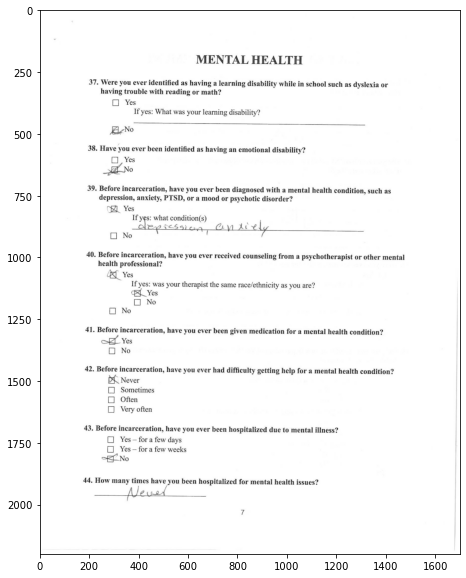

In [15]:
img = cv2.imread('page6.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

In [ ]:
extractor = CheckboxExtractor()
checkboxes = extractor.detect_checkbox(gray)    
tick_list = list(map(lambda x: extractor.is_ticked(gray[x[1]:x[3], x[0]:x[2]]), checkboxes))
checkboxes = np.hstack([checkboxes, np.array(tick_list).reshape(-1,1)]) # [x1,y1,x2,y2,is_ticked]

temp_checkboxes = np.hstack([checkboxes, (checkboxes[:,1:2] + checkboxes[:,3:4])/2])


In [ ]:
# ret = img.copy()
list_cbes = []
column_ids  = []
row_ids = []
for i in range(len(checkboxes)):
  x1,y1,x2,y2,_is_tick = checkboxes[i]
  ret = cv2.rectangle(ret,(x1,y1), (x2,y2), (0,255,0), 2)
  _column_id = np.where((all_columns_np[:,0] < x1) & (all_columns_np[:,2] > x2))[0][0]
  column_ids += [_column_id]

  checkbox_coor = checkboxes[i:i+1, :]
  _iou = np_vec_no_jit_iou(checkbox_coor[:,:4], all_rows_np)
  row_ids += [np.argmax(_iou)]
  # print(row_ids[-1])
  # print(_column_id)
plt.imshow(ret)

In [49]:
len(row_ids)

68

In [51]:
QUESTOON_LIST_11 = {
    57: 'How many schools did you go to?',
    58: 'Did you ever skip classes?',
    59: 'Were you ever kicked out of a class?',
    60: 'Were you ever sent home from school due to behavior?',
    61: 'Were you ever suspended?',
    62: 'Were you ever expelled?',
    63: 'Were you suspended in-school or out of school?'
}
COLUMNS_LIST_11 = [ 'Elementary school', 'Middle school', 'High school' ]

In [84]:
np.unique(row_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

In [85]:
_question_id = 58
question_text = QUESTOON_LIST_11[_question_id]
for _column_id in range(3):
    column_text = COLUMNS_LIST_11[_column_id]
    _checkbox_ids = list(filter(lambda x: ( int(question_of_rows[row_ids[x]]) == _question_id ) and (column_ids[x] == _column_id), range(len(checkboxes)) ))
    # print(len(_checkbox_ids))

In [90]:
ANSWER_TEXT = {
    57: ['One', 'Two', 'More than two'],
    58: ['Once', 'A few times', 'Often', 'Never'],
    59: ['Once', 'A few times', 'Often', 'Never'],
    60: ['Once', 'A few times', 'Often', 'Never'],
    61: ['Once', 'A few times', 'Often', 'Never'],
    62: ['Yes', 'No'],
    63: [ 'In-school', 'Out-of-school' ]
}

In [93]:
_id_offset = 0
result = ''
for _question_id in range(57, 64):

    print('-----------------------------------------------------')
    question_text = QUESTOON_LIST_11[_question_id]
    print(f'Question {_question_id}: {question_text}')
    result += f'Question {_question_id}: {question_text}\n'
    for _column_id in range(3):
        column_text = COLUMNS_LIST_11[_column_id]
        print(f'\tColumn: {column_text}')
        result += f'\tColumn: {column_text}\n'
        _checkbox_ids = list(filter(lambda x: ( int(question_of_rows[row_ids[x]]) == _question_id ) and (column_ids[x] == _column_id) and (checkboxes[x][4] == 1), range(len(checkboxes)) ))
        # checkbox_of_column = checkboxes[_checkbox_ids] 
        # true_answer = np.where(checkbox_of_column[:, 4] == 1)
        if len(_checkbox_ids) > 0:
            for _checkbox_id in _checkbox_ids:
                print(f'\t\t{ANSWER_TEXT[_question_id][row_ids[_checkbox_id] - _id_offset]}')
                result += f'\t\t{ANSWER_TEXT[_question_id][row_ids[_checkbox_id] - _id_offset]}\n'
    _id_offset += len(ANSWER_TEXT[_question_id])
print('Done')

-----------------------------------------------------
Question 57: How many schools did you go to?
	Column: Elementary school
		One
	Column: Middle school
		Two
		More than two
	Column: High school
-----------------------------------------------------
Question 58: Did you ever skip classes?
	Column: Elementary school
		Never
	Column: Middle school
		A few times
	Column: High school
		A few times
-----------------------------------------------------
Question 59: Were you ever kicked out of a class?
	Column: Elementary school
		Never
	Column: Middle school
		Once
	Column: High school
		Never
-----------------------------------------------------
Question 60: Were you ever sent home from school due to behavior?
	Column: Elementary school
		Never
	Column: Middle school
		Never
	Column: High school
		Never
-----------------------------------------------------
Question 61: Were you ever suspended?
	Column: Elementary school
		Never
	Column: Middle school
		Never
	Column: High school
		Never
-

In [94]:
with open('result.txt', 'w') as f:
    f.write(result)

In [67]:
len(question_of_rows)

23

In [55]:
[row.split('_')[0] for row in all_rows['class']]

['57',
 '57',
 '57',
 '58',
 '58',
 '58',
 '58',
 '59',
 '59',
 '59',
 '59',
 '60',
 '60',
 '60',
 '60',
 '61',
 '61',
 '61',
 '61',
 '62',
 '62',
 '63',
 '63']